# Lab 3
##Part B Building a CNN

**Deadline**: June 5, 9pm


## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/open?id=1kTcucRGcAI6jx80gE-YbW1hNfYAH3-rU

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

##1. Model Building and Sanity Checking
###Part (a) Convolutional Network

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional? What about other decisions like pooling layers, activation functions, number of channels / hidden units.

### My Convolutional nerual network contains 10 layers, which are composed of 4 convolutional layers, 4 max pooling layers, and 2 fully connected layers. I will apply Relu activation function to all the outputs of the hidden layers. 
###1. Choice of convolutional layers: the convolutional layers are chosen such that the size of the output channel is double the size of the input channel. The reasoning behind this is that we do not want to loss too much information in each layer. By applying more filters before the previous layer, more features will be detected to compensate for the fact that the actual size (width * height) of the input is decreasing for each convolution layer. But we also want to limit the number of output channels before the fully connected layers such that it is not too computationally expensive. Padding is not applied to all inputs for the purpose of this assignment, because the edges of all images do not contain useful information. The kernal size is chosen to be an odd dimension (either 3 * 3 or 5 * 5) for ease of computation. 
###2. Choice of fully connected layers: the number of units in each hidden layer for the fully-connected is reduced to consolidate information and to remove useless information for the current task.
###3. Choice of activation functions: we use Relu activation function for this assigment as it generally performs well and is not computationally expensive. 
###4. Choice of pooling: pooling layers are used to reduce the input size (width * height) for each layer(consolidate information). A Max pooling is chosen because max pooling generally works better than average pooling. The kernal size and the stride are both 2 for ease of computation.
###5. number of layers: the number of layers are chosen based on the size of the dataset. Having a large model is helpful only when there is enough data to train the model. A small dataset is not capable of training a large model. I tried a few models with different number of layers and I found that this model works well (But I will not show the process of tuning this hyperparameter in part 4).


In [0]:
class net(nn.Module):
  def __init__(self):
    super(net,self).__init__()
    self.name = "CNN"
    self.conv1 = nn.Conv2d(3, 5, 5) 
    self.conv2 = nn.Conv2d(5, 10, 3) 
    self.conv3 = nn.Conv2d(10, 20, 7) 
    self.conv4 = nn.Conv2d(20, 40, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(40 * 10 * 10, 2048)
    self.fc2 = nn.Linear(2048, 9)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) #output size: 5*220*220; after pooling, output size: 5*110*110
    x = self.pool(F.relu(self.conv2(x))) #output size: 10*108*108; after pooling, output size: 20*54*54
    x = self.pool(F.relu(self.conv3(x))) #output size: 20*48*48; after pooling, output size: 40*24*24
    x = self.pool(F.relu(self.conv4(x))) #output size: 40*20*20; after pooling, output size: 40*10*10
    x = x.view(-1, 40 * 10 * 10)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


###Part (b) Training  Code
Write code to train your neural network given some training data. Your training code should make it easy to
tweak hyperparameters. Make sure that you are checkpointing your models from time to time (the frequency
is up to you). Explain your choice of loss function and optimizer.


###1. I use the cross-entropy loss as my loss function because this is not a binary classification problem and we can not use binary-cross entropy loss. The cross-entropy loss is generally used for N-ary classification problems. It also has nice properties to avoid learning slow-down around an activation value of 0 or 1 and to help with the vanishing gradient problem from which deep neural networks suffer.  
###2. I use the Adaptive Moment Estimation (Adam) as my optimizer. Adam is the go-to optimizer for modern practioners. Also, given that our network contains a lot of layers, Adam is a better choice as it is faster. 

In [0]:
def train_net(model, batch_size=64 ,learning_rate=0.01, num_epochs=30, weight_decay=0.0):
  torch.manual_seed(1000)
  train_loader, val_loader, test_loader = get_data_loader(batch_size)
  ###########################################
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  ###########################################
  #set up some numpy arrays to store the training/validation loss/accuarcy
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  iters = []
  ###########################################
  for epoch in range(num_epochs):
    for imgs, labels in train_loader:
      output = model(imgs)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #check point: save the current training information
    iters.append(epoch + 1)
    train_acc[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion)
    val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
    print(("Epoch {}: Train acc: {}, Train loss: {} |" + "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}" .format(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)
    
  #plotting 
  plt.title("Train vs. Validation Loss")
  plt.plot(iters, train_loss, label = "Train")
  plt.plot(iters, val_loss, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()
  
  plt.title("Train vs. Validation Accuracy")
  plt.plot(iters, train_acc, label = "Train")
  plt.plot(iters, val_acc, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  
  print("Final Training Accuracy: {}" .format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

def evaluate(model, loader, criterion):
  total_loss = 0.0
  total_acc = 0.0
  total_img = 0.0
  for i, (imgs, labels) in enumerate(loader):
    output = model(imgs)
    loss = criterion(output, labels)
    pred = output.max(1, keepdim=True)[1]
    total_acc += pred.eq(labels.view_as(pred)).sum().item()
    total_loss += loss
    total_img += len(labels)
  acc = total_acc / total_img
  loss = float(total_loss) / (i+1)  
  return acc, loss

###Part (c) Overfit to a Small Dataset
One way to sanity check our neural network model and training code is to check whether the model is capable
of overfitting a small dataset. Construct a small dataset (e.g. 1-2 image per class). Then show that your
model and training code is capable of overfitting on that small dataset. You should be able to obtain a 100%
training accuracy on that small dataset relatively quickly.
If your model cannot overfit the small dataset quickly, then there is a bug in either your model code and/or
your training code. Fix the issues before you proceed to the next step.

###In order to get the overfit dataset, I manually picked two images from each class and put all the overfit data under the directory named overfit_data. For the validation data, I used an arbitrary dataset(But it is not necessary to have in this part.) To make the model overfit the dataset, I trained the model for 20 epoches. The training loss kept decreasing and the training accuarcy kept increasing throughout the training process. However, the validation loss increased after 8 epochs and the validation accuarcy maintained roughly the same after that point. This is a sign of overfitting. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip '/content/gdrive/My Drive/data.zip'

In [0]:
def get_overfit_data_loader(batch_size=64):
  transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  train_set = torchvision.datasets.ImageFolder(root='./data/overfit_data', transform=transform)
  val_set = torchvision.datasets.ImageFolder(root='./data/validation', transform=transform)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
                                        
  return train_loader, val_loader

def train_net_overfit(model, batch_size=64 ,learning_rate=0.001, num_epochs=30):
  torch.manual_seed(100)
  train_loader, val_loader = get_overfit_data_loader(batch_size)
  ###########################################
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  ###########################################
  #set up some numpy arrays to store the training/validation loss/accuarcy
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  iters = []
  ###########################################
  for epoch in range(num_epochs):
    for (imgs, labels) in train_loader:
      output = model(imgs)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #check point: save the current training information
    iters.append(epoch + 1)
    train_acc[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion)
    val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
    print(("Epoch {}: Train acc: {}, Train loss: {} |" + "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}" .format(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)
    
  #plotting 
  plt.title("Train vs. Validation Loss")
  plt.plot(iters, train_loss, label = "Train")
  plt.plot(iters, val_loss, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()
  
  plt.title("Train vs. Validation Accuracy")
  plt.plot(iters, train_acc, label = "Train")
  plt.plot(iters, val_acc, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  
  print("Final Training Accuracy: {}" .format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.2222222222222222, Train loss: 2.1254005432128906 |Validation acc: 0.11940298507462686, Validation loss: 2.1793062686920166
Epoch 2: Train acc: 1.0, Train loss: 1.9135854244232178 |Validation acc: 0.3582089552238806, Validation loss: 2.1475601196289062
Epoch 3: Train acc: 1.0, Train loss: 1.517685890197754 |Validation acc: 0.3333333333333333, Validation loss: 2.1959779262542725
Epoch 4: Train acc: 1.0, Train loss: 0.9470188617706299 |Validation acc: 0.36318407960199006, Validation loss: 2.4054746627807617
Epoch 5: Train acc: 1.0, Train loss: 0.42716461420059204 |Validation acc: 0.36318407960199006, Validation loss: 2.852468729019165
Epoch 6: Train acc: 1.0, Train loss: 0.18442471325397491 |Validation acc: 0.31840796019900497, Validation loss: 5.216335773468018
Epoch 7: Train acc: 1.0, Train loss: 0.05287589132785797 |Validation acc: 0.31840796019900497, Validation loss: 5.338686943054199
Epoch 8: Train acc: 0.9444444444444444, Train loss: 0.06966294348239899 |Valid

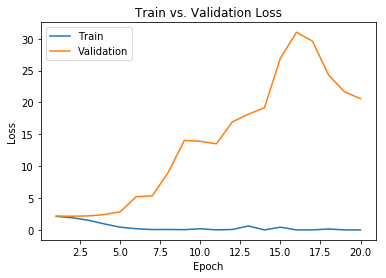

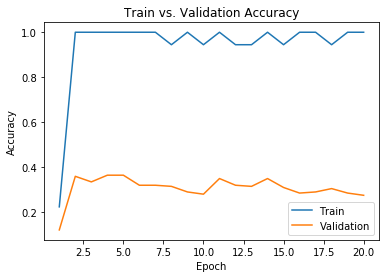

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.2736318407960199


In [0]:
overfit_model = net()
train_net_overfit(overfit_model, batch_size=64 ,learning_rate=0.001, num_epochs=20)

##2. Data Loading and Splitting
Download the anonymized data collected by you and your classmates. Split the data into training, validation,
and test sets.
Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!
Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?
For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
) For this portion only, you are free to look up tutorials or other code on the internet to help you.


###For data spliting, I created three subdirectories (train, validation, test) under the data directory. For each directory, there are nine folders denoting the labels of the images. I split my data into 70/15/15 and I also decided to split different students into the three dataset. Given that the samples are taken from 50 students, the 70/15/15 split corresponds roughly to 35/7.5/7.5 students for training, validation and testing. It also corresponds to 815/175/175 images as there are 1164 images in total. I decided to use the order provided in the original data set to select students for datasets, meaning 1-35 is for training set, 35-43 is for validation set and 44-50 is for test set. The splitting process is random as the original given order is random.  There are several reasons behind this data splitting process:
###1. Splitting students into training, validation and test sets ensures that the test set provides a fair evaluation. All the test data contain hands never seen by the model before. If the model is able to perform well on those pure data, it is a well trained model. 
###2. The 70/15/15 spilt represents a good balance between training quality and testing accuracy. We want the model to train on large dataset but we also need enough test data to ensure the evaluation accuracy. I decided to use this ratio as it is suggested by many machine learning literatures.
###3. There are two main reasons that I did not do a random selection on the entire data set. First, it is possible that the test set is too similar to the training set. The test set might contain students that are already seen during the training process. Second, we want to make sure that the model is trained on the all the letters before it is tested. And the easiset fix to these issues is to split students into different datasets. 

In [0]:
def get_data_loader(batch_size=64):
  transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  train_set = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
  val_set = torchvision.datasets.ImageFolder(root='./data/validation', transform=transform)
  test_set = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
  
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)
                                            
  return train_loader, val_loader, test_loader


##3. Training
Train your first network on your training set. Plot the training curve, and include your plot in your writeup.
Make sure that you are checkpointing frequently!


###For the first model, I chose to use a batch size of 64, a learning rate of 0.001, 30 epochs and a weight decay of 0. 

Epoch 1: Train acc: 0.5516372795969773, Train loss: 1.3974339411808894 |Validation acc: 0.5074626865671642, Validation loss: 1.9549553394317627
Epoch 2: Train acc: 0.7531486146095718, Train loss: 0.7883695455697867 |Validation acc: 0.6716417910447762, Validation loss: 0.8542168736457825
Epoch 3: Train acc: 0.801007556675063, Train loss: 0.607848937694843 |Validation acc: 0.6915422885572139, Validation loss: 1.0824499130249023
Epoch 4: Train acc: 0.8614609571788413, Train loss: 0.4201831084031325 |Validation acc: 0.736318407960199, Validation loss: 0.6540730595588684
Epoch 5: Train acc: 0.9206549118387909, Train loss: 0.26027905024014986 |Validation acc: 0.7711442786069652, Validation loss: 0.6252180337905884
Epoch 6: Train acc: 0.9282115869017632, Train loss: 0.20003846975473258 |Validation acc: 0.7661691542288557, Validation loss: 0.6655543446540833
Epoch 7: Train acc: 0.9319899244332494, Train loss: 0.16663872278653657 |Validation acc: 0.7661691542288557, Validation loss: 0.678735077

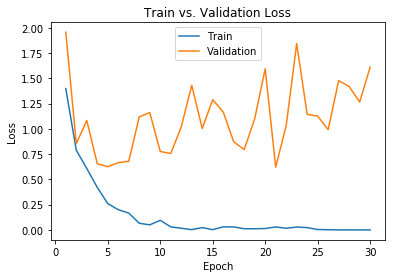

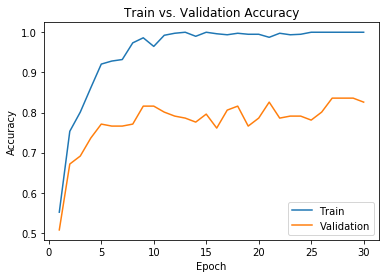

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8258706467661692


In [0]:
part3_net = net()
train_net(part3_net, batch_size=64, learning_rate=0.001, num_epochs=30, weight_decay=0.0)

##4. Hyperparameter Search
###Part (a) 
List 3 hyperparameters that you think are most worth tuning.

###In part three, the model overfits the training data fairly quickly (around 12 epochs). To improve the performance of the model, the following parameters are tunned:
###1. Weight decay: this hyperparameter is used to fix the problem of overfitting. Weight decay is used to prevent the model overly relying on one specific pixel.
###2. Learning rate: this parameter is used to improve the speed and loss of training. Our goal is to find the optimal learning rate that provides the smallest loss.
###3. Number of epoches: this is another technique used to prevent overfitting. This is also known as early stopping. This technique will be applied to the end to the model that has the highest validation accuracy historically(i.e.during training).



###Part (b)
Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

###My tunning strategy is to change one hyperparameter at a time while keeping the other parameters the same. The quality of the model will be assessed based on the validation accuracy.
###To fix the overfitting problem, I decided to increase the weight decay to remove the reliability on specific picxels. I also apply early stopping to prevent overfitting. I will also look for the optimal learning rate that produces the highest validation accuracy.

###Set1: batch_size=64, learning_rate=0.005, num_epochs=30, weight_decay=0
###My first two trials are used to find the optimal learning rate. I first increase the learning rate to see whether the model performs better. 


Epoch 1: Train acc: 0.24685138539042822, Train loss: 2.0255885491004357 |Validation acc: 0.263681592039801, Validation loss: 2.188499927520752
Epoch 2: Train acc: 0.593198992443325, Train loss: 1.1304921370286207 |Validation acc: 0.527363184079602, Validation loss: 1.254584789276123
Epoch 3: Train acc: 0.7531486146095718, Train loss: 0.7434161993173453 |Validation acc: 0.6517412935323383, Validation loss: 1.2540937662124634
Epoch 4: Train acc: 0.8173803526448362, Train loss: 0.5263153956486628 |Validation acc: 0.681592039800995, Validation loss: 0.8121084570884705
Epoch 5: Train acc: 0.8753148614609572, Train loss: 0.3532048005324144 |Validation acc: 0.7213930348258707, Validation loss: 0.8197391033172607
Epoch 6: Train acc: 0.8652392947103275, Train loss: 0.3422360420227051 |Validation acc: 0.6766169154228856, Validation loss: 1.0752569437026978
Epoch 7: Train acc: 0.9143576826196473, Train loss: 0.2402311655191275 |Validation acc: 0.736318407960199, Validation loss: 1.135966300964355

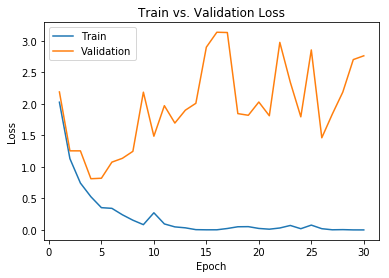

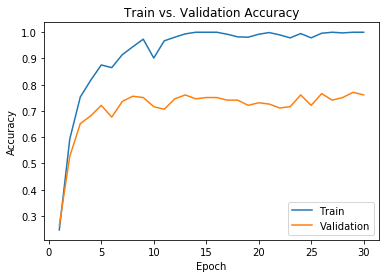

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7611940298507462


In [0]:
part4_net1 = net()
train_net(part4_net1, batch_size=64, learning_rate=0.005, num_epochs=30, weight_decay=0)

###Set2: batch_size=64, learning_rate=0.0005, num_epochs=30, weight_decay=0
###In this trial, I will decrease the learning rate to see if the model is better.

Epoch 1: Train acc: 0.473551637279597, Train loss: 1.8860078958364634 |Validation acc: 0.4079601990049751, Validation loss: 1.9509999752044678
Epoch 2: Train acc: 0.5869017632241813, Train loss: 1.1871498548067534 |Validation acc: 0.4925373134328358, Validation loss: 1.7105175256729126
Epoch 3: Train acc: 0.7279596977329975, Train loss: 0.8582639694213867 |Validation acc: 0.6467661691542289, Validation loss: 1.5807864665985107
Epoch 4: Train acc: 0.8022670025188917, Train loss: 0.6506953606238732 |Validation acc: 0.7014925373134329, Validation loss: 0.8903468251228333
Epoch 5: Train acc: 0.8425692695214105, Train loss: 0.5645832281846267 |Validation acc: 0.736318407960199, Validation loss: 0.7886892557144165
Epoch 6: Train acc: 0.8047858942065491, Train loss: 0.5970052205599271 |Validation acc: 0.7164179104477612, Validation loss: 0.7233508825302124
Epoch 7: Train acc: 0.8387909319899244, Train loss: 0.47151506864107573 |Validation acc: 0.7213930348258707, Validation loss: 0.8067474961

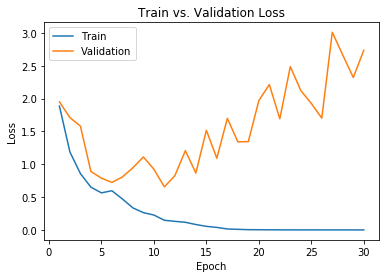

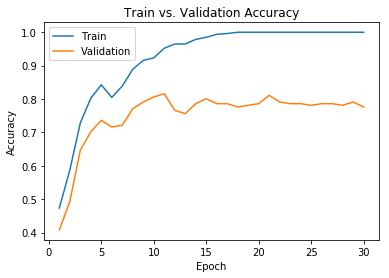

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7761194029850746


In [0]:
part4_net2 = net()
train_net(part4_net2, batch_size=64, learning_rate=0.0005, num_epochs=30, weight_decay=0)

###It seems that 0.0005 is a good learning rate as the highest accuracy is achieved with this learning rate.

###Set3: batch_size=64, learning_rate=0.0005, num_epochs=30, weight_decay=0.01
###This trial is to fix the overfit problem by adding a weight decay.

Epoch 1: Train acc: 0.3110831234256927, Train loss: 2.1557376568134012 |Validation acc: 0.31343283582089554, Validation loss: 2.1657092571258545
Epoch 2: Train acc: 0.5617128463476071, Train loss: 1.3989539513221154 |Validation acc: 0.48258706467661694, Validation loss: 1.7146902084350586
Epoch 3: Train acc: 0.6473551637279596, Train loss: 1.0950186069195087 |Validation acc: 0.6019900497512438, Validation loss: 1.654382586479187
Epoch 4: Train acc: 0.7531486146095718, Train loss: 0.8029903265146109 |Validation acc: 0.6766169154228856, Validation loss: 1.2499651908874512
Epoch 5: Train acc: 0.7304785894206549, Train loss: 0.7663326263427734 |Validation acc: 0.6119402985074627, Validation loss: 1.078850507736206
Epoch 6: Train acc: 0.7153652392947103, Train loss: 0.7992319693932166 |Validation acc: 0.6716417910447762, Validation loss: 1.0562652349472046
Epoch 7: Train acc: 0.8022670025188917, Train loss: 0.5446036045367901 |Validation acc: 0.7213930348258707, Validation loss: 0.924192905

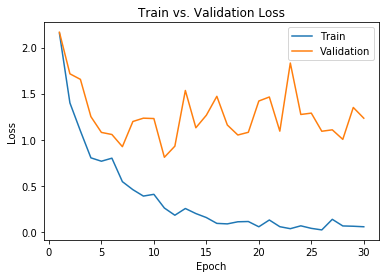

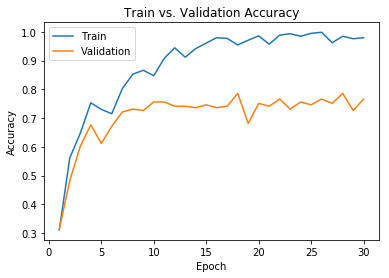

Final Training Accuracy: 0.9798488664987406
Final Validation Accuracy: 0.7661691542288557


In [0]:
part4_net3 = net()
train_net(part4_net3, batch_size=64, learning_rate=0.0005, num_epochs=30, weight_decay=0.01)

###It seems that the overfitting is reduced. But the validation accuracy also decreases. So for the next trial, I will try a smaller weight_decay to see what happens.

###Set4: batch_size=64, learning_rate=0.0005, num_epochs=30, weight_decay=0.0001

Epoch 1: Train acc: 0.49622166246851385, Train loss: 1.8990808633657603 |Validation acc: 0.43283582089552236, Validation loss: 1.9599753618240356
Epoch 2: Train acc: 0.5793450881612091, Train loss: 1.1875342589158278 |Validation acc: 0.4925373134328358, Validation loss: 1.7190920114517212
Epoch 3: Train acc: 0.72544080604534, Train loss: 0.8651970349825345 |Validation acc: 0.6517412935323383, Validation loss: 1.5800637006759644
Epoch 4: Train acc: 0.801007556675063, Train loss: 0.6584084584162786 |Validation acc: 0.6915422885572139, Validation loss: 0.909620463848114
Epoch 5: Train acc: 0.8337531486146096, Train loss: 0.5684751363900992 |Validation acc: 0.7263681592039801, Validation loss: 0.8139609694480896
Epoch 6: Train acc: 0.8110831234256927, Train loss: 0.5877249057476337 |Validation acc: 0.7114427860696517, Validation loss: 0.7571495771408081
Epoch 7: Train acc: 0.845088161209068, Train loss: 0.45879316329956055 |Validation acc: 0.7263681592039801, Validation loss: 0.83797037601

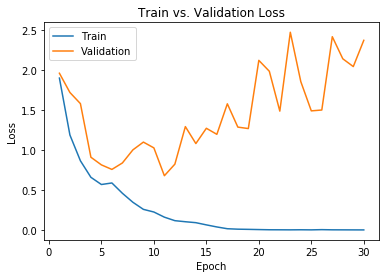

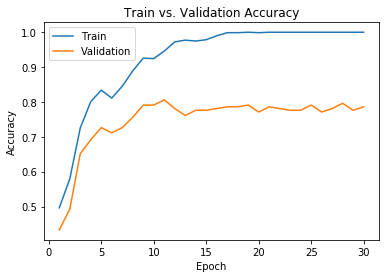

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7860696517412935


In [0]:
part4_net4 = net()
train_net(part4_net4, batch_size=64, learning_rate=0.0005, num_epochs=30, weight_decay=0.0001)

###After the above two trials, I found that the weight decay helps with overfitting, but it sacrifices validation accuracy. For the next trial, I will apply early stopping to prevent overfitting.

###Set5: batch_size=64, learning_rate=0.0005, num_epochs=11, weight_decay=0
###The last trial is to find the best model. I looked at all the models trained so far and picked the model that has small loss and large accuracy. I adjust the number of epochs such that the model does not overfit nor underfit the training set.

Epoch 1: Train acc: 0.473551637279597, Train loss: 1.8860078958364634 |Validation acc: 0.4079601990049751, Validation loss: 1.9509999752044678
Epoch 2: Train acc: 0.5869017632241813, Train loss: 1.1871498548067534 |Validation acc: 0.4925373134328358, Validation loss: 1.7105175256729126
Epoch 3: Train acc: 0.7279596977329975, Train loss: 0.8582639694213867 |Validation acc: 0.6467661691542289, Validation loss: 1.5807864665985107
Epoch 4: Train acc: 0.8022670025188917, Train loss: 0.6506953606238732 |Validation acc: 0.7014925373134329, Validation loss: 0.8903468251228333
Epoch 5: Train acc: 0.8425692695214105, Train loss: 0.5645832281846267 |Validation acc: 0.736318407960199, Validation loss: 0.7886892557144165
Epoch 6: Train acc: 0.8047858942065491, Train loss: 0.5970052205599271 |Validation acc: 0.7164179104477612, Validation loss: 0.7233508825302124
Epoch 7: Train acc: 0.8387909319899244, Train loss: 0.47151506864107573 |Validation acc: 0.7213930348258707, Validation loss: 0.8067474961

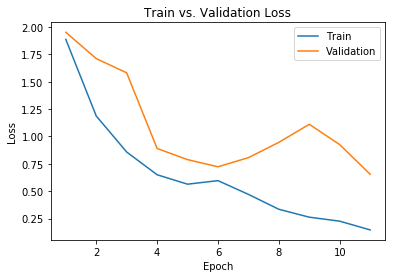

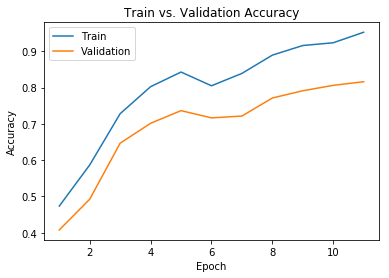

Final Training Accuracy: 0.9521410579345088
Final Validation Accuracy: 0.8159203980099502


In [0]:
part4_net5 = net()
train_net(part4_net5, batch_size=64, learning_rate=0.0005, num_epochs=11, weight_decay=0)

###Part (c)
Choose the best model out of all the ones that you have trained. Justify your choice.


###The criteria for selecting the best model is the validation accuarcy. Validation accuarcy measure the quality of predictions made on a the validation dataset. 
###Considering the above criteria, the last model is chosen to be the best model as it provides high validation accuarcy (0.82) and low validation loss(0.496). 


###part (d)
Report the test accuracy of your best model. You should only do this step once.

In [0]:
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)
test_acc, test_loss = evaluate(part4_net5, test_loader, nn.CrossEntropyLoss())
print("Final test loss: {}" .format(test_loss))
print("Final test Accuracy: {}" .format(test_acc))

Final test loss: 1.0246820449829102
Final test Accuracy: 0.7380952380952381


###The test accuracy is smaller than the validation accuracy by 8%. It is a bit too low but reasonable. First of all, the hyperparameters are tuned based on the validation accuracy, so the validation set is not considered to be pure anymore. Also, the validation and test data are choosen arbitrarily. After checking the data manually, I found that there are some photos containg black background and hands with wired angles in the test set. Therefore, the dicrepancy between the validation and test accuracy is reasonable.

##5. Transfer Learning
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.
One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed Transfer
Learning. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.
As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.


###Part (a) 
Compute the AlexNet features for each of your training, validation, and test data. 

Save the computed features. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run alexnet.features once for
each image, and save the result.



In [0]:
import torchvision.models
alex_net = torchvision.models.alexnet(pretrained=True)

train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

train_features, val_features, test_features = [], [], []
for imgs, labels in iter(train_loader):
  train_features.append((alex_net.features(imgs), labels))


for imgs, labels in iter(val_loader):
  val_features.append((alex_net.features(imgs), labels))
  

for imgs, labels in iter(test_loader):
  test_features.append((alex_net.features(imgs), labels))
 

np.save("train_features.npy", train_features)
np.save("val_features.npy", val_features)
np.save("test_features.npy", test_features)
train_features.clear()
val_features.clear()
test_features.clear()

###Part (b)
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.
Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?




###The model contains fully-connected layers only as the alex net features already produce output from a well trained convolutional model. The purpose of this model is to add classification layers to consolidate information and produce prediction. 
###1. Activation function: I chose relu as my activation function as it generally performs well and is used in most cases.  
###2. Number of hidden units: the number of hidden units decreases for each layer. The purpose is to consolidation information and get rid of useless information. The number of output units matches the number of labels we have for the data.
###3. Number of layers: I chose to use two layers for the purpose of this task. This is a balance between time and accuarcy. We do not want to spend too much time on training the network, but we still well trained model. Two layer allows the number of hidden units not to decay too much and it takes reasonable amount of time to train.


In [0]:
class alex_classifier(nn.Module):
  def __init__(self):
    super(alex_classifier, self).__init__()
    self.name = "classifier"
    self.fc1 = nn.Linear(256 * 6 * 6, 4096)
    self.fc2 = nn.Linear(4096, 9)
     
  def forward(self, x):
    x = x.view(-1, 256 * 6 * 6)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

###Part (c)
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.


###There are three hyperparameters I tuned to improve the behaviour of the model. They are batch size, learning_rate and num_epochs. The tuning strategy is almost identical to part 4. I first found the optimal learning rate by observing whether the validation accuracy increase. After that, I found the appropriate batch size for this problem. A batch size that is too large is computationally expensive, but it reduces noise. While a batch size that is too small produces a lot of noise. My goal was to fing the optimal batch size in this problem. So I tried some commonly used batch size. (e.x 32, 64, 128) The last step is to reduce the num_epochs to allow early stopping. After a few trials, the best model I got produces a validation loss of 0.128 and a validation accuarcy of 0.965.

In [0]:
def train_alex_classifier(model, batch_size=64 ,learning_rate=0.01, num_epochs=30):
  train_features = np.load("train_features.npy", allow_pickle=True)
  val_features = np.load("val_features.npy", allow_pickle=True)
  ###########################################
  #Fix Random Seed
  torch.manual_seed(1000)
  ###########################################
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  ###########################################
  #set up some numpy arrays to store the training/validation loss/accuarcy
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  iters = []
  ###########################################
  for epoch in range(num_epochs):
    for imgs, labels in train_features:
      output = model(imgs)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #check point: save the current training information
    iters.append(epoch + 1)
    train_acc[epoch], train_loss[epoch] = evaluate_alex(model, train_features, criterion)
    val_acc[epoch], val_loss[epoch] = evaluate_alex(model, val_features, criterion)
    print(("Epoch {}: Train acc: {}, Train loss: {} |" + "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}" .format(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)
    
  #plotting 
  plt.title("Train vs. Validation Loss")
  plt.plot(iters, train_loss, label = "Train")
  plt.plot(iters, val_loss, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()
  
  plt.title("Train vs. Validation Accuracy")
  plt.plot(iters, train_acc, label = "Train")
  plt.plot(iters, val_acc, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  
  print("Final Training Accuracy: {}" .format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [0]:
def evaluate_alex(model, features, criterion):
  total_loss = 0.0
  total_acc = 0.0
  total_img = 0.0
  for i, (imgs, labels) in enumerate(features):
    output = model(imgs)
    loss = criterion(output, labels)
    pred = output.max(1, keepdim=True)[1]
    total_acc += pred.eq(labels.view_as(pred)).sum().item()
    total_loss += loss
    total_img += len(labels)
  acc = total_acc / total_img
  loss = float(total_loss) / (i+1)  
  return acc, loss
  

Epoch 1: Train acc: 0.9206549118387909, Train loss: 0.29405709413381725 |Validation acc: 0.9054726368159204, Validation loss: 0.3732321262359619
Epoch 2: Train acc: 0.9861460957178841, Train loss: 0.09892848821786734 |Validation acc: 0.9303482587064676, Validation loss: 0.2445451021194458
Epoch 3: Train acc: 0.9899244332493703, Train loss: 0.053163427572983965 |Validation acc: 0.9054726368159204, Validation loss: 0.2583015263080597
Epoch 4: Train acc: 1.0, Train loss: 0.017765868168610793 |Validation acc: 0.9601990049751243, Validation loss: 0.15675519406795502
Epoch 5: Train acc: 1.0, Train loss: 0.014954286125990061 |Validation acc: 0.9552238805970149, Validation loss: 0.12601415812969208
Epoch 6: Train acc: 1.0, Train loss: 0.00949257669540552 |Validation acc: 0.9502487562189055, Validation loss: 0.16121786832809448
Epoch 7: Train acc: 1.0, Train loss: 0.007011278890646421 |Validation acc: 0.9651741293532339, Validation loss: 0.12836149334907532
Epoch 8: Train acc: 1.0, Train loss: 

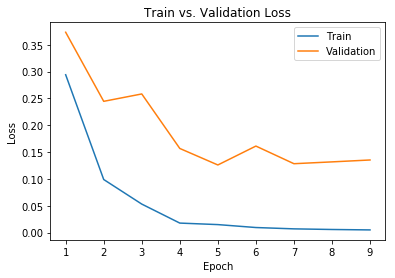

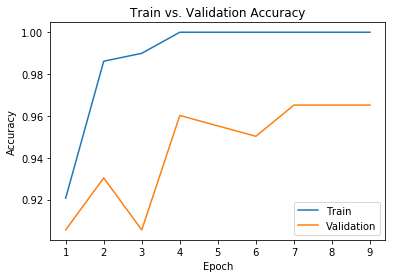

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9651741293532339


In [0]:
part5_net = alex_classifier()
train_alex_classifier(part5_net, batch_size=64 ,learning_rate=0.0001, num_epochs=9)

###As the validation accuracy stops increasing after epoch 7, we decided to stop the training at epoch 7 and choose that to be the best model. 

###In part d, epoch = 6 in model path as 0 is counted as the first element. 

###Part (d)
Report the test accuracy of your best model. How does the test accuracy compare to part 4(d)?


In [0]:
best_net = alex_classifier()
model_path = "model_{0}_bs{1}_lr{2}_epoch{3}" .format(best_net.name, 64, 0.0001, 6)
state = torch.load(model_path)
best_net.load_state_dict(state)
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)
test_features = np.load("test_features.npy", allow_pickle=True)

test_acc, test_loss = evaluate_alex(best_net, test_features, nn.CrossEntropyLoss())
print("Final test loss: {}" .format(test_loss))
print("Final test Accuracy: {}" .format(test_acc))

Final test loss: 0.10391488671302795
Final test Accuracy: 0.9642857142857143


###The test accuracy is 96.43% which is higher than the accuracy (74%) in part 4. This makes sense because Alex Net is a pretrained model that has been already trained on a large amount of datasets and it  generally works well in all kinds of image classification problems. That's why transfer learning is one popular way to avoid overfitting when the dataset is insufficient.